In [4]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from datetime import date
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

from scipy.sparse import csr_matrix

In [5]:
# get data and create sparse matrix


# pomysł klient_id - łączna wydana suma - ilość transakcji
# ile wydaje klient w zależności od tego ile razy robi zakupy


# dbscan z przykładem: https://www.kdnuggets.com/2022/08/implementing-dbscan-python.html

df = pd.read_csv('edzd_trans_data.csv')
for col in df.columns:
    print("Type of column", col, "is", df[col].dtype)

#Type of column transaction_id is object
#Type of column sales_datetime is object
#Type of column customer_id is object - do db-scan
#Type of column product_id is object - do db-scan
#Type of column quantity is float64
#Type of column price is float64 - do db-scan ewentualnie
#Type of column category_id is int64 - do db-scan ewentualnie
#Type of column parent_id is int64 ?
#Type of column store_id is int64
#Type of column department_id is int64
#Type of column salesperson_id is int64
    
# change the type of product_id to int and number them from 1 to number of different product_ids
df['product_id'] = df['product_id'].astype('category')
df['product_id'] = df['product_id'].cat.codes

# change the type of transaction_id to int and number them from 1 to number of different transaction_ids
df['transaction_id'] = df['transaction_id'].astype('category')
df['transaction_id'] = df['transaction_id'].cat.codes

# Create a sparse matrix of the data group it by transaction_id and product_id
# we want

Type of column transaction_id is object
Type of column sales_datetime is object
Type of column customer_id is object
Type of column product_id is object
Type of column quantity is float64
Type of column price is float64
Type of column category_id is int64
Type of column parent_id is int64
Type of column store_id is int64
Type of column department_id is int64
Type of column salesperson_id is int64


In [3]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [6]:
# data should always be
# [[customer_id 1, sth related to customer 1, ...], [customer_id 2, sth related to customer 2, ...], ...]

# filter out customer_id = -1
df_filtered = df[df['customer_id'] != '-1']

# change customed_id to numeric
le = LabelEncoder()
df_filtered['customer_id'] = le.fit_transform(df_filtered['customer_id'])
# df_filtered = pd.get_dummies(df_filtered, columns=['customer_id'])

print(df_filtered)
print(type(df_filtered))

         transaction_id       sales_datetime  customer_id  product_id  \
6789             501717  2011-01-03 10:06:00        92354       26838   
7478            2418844  2011-01-03 12:01:00       113131       44520   
7479            2418844  2011-01-03 12:01:00       113131       57544   
8581            3704341  2011-01-03 13:49:00         2419       27992   
8582            3704341  2011-01-03 13:49:00         2419       27992   
...                 ...                  ...          ...         ...   
8159528         3026494  2014-10-01 20:51:00       119861       31054   
8159529          797946  2014-10-01 20:54:00         7589       51188   
8159530          797946  2014-10-01 20:54:00         7589       44626   
8159532          476485  2014-10-01 20:56:00        61463       39927   
8159533          476485  2014-10-01 20:56:00        61463       30249   

         quantity    price  category_id  parent_id  store_id  department_id  \
6789          1.0  35.0000          110     

/tmp/ipykernel_29288/2006887328.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['customer_id'] = le.fit_transform(df_filtered['customer_id'])


In [11]:
# use the product_id, quantity, price, and category_id columns to cluster customers into
# groups of those who have similar purchasing habits

# lets take only qantity and price
df_shortened_transactions = df_filtered[['transaction_id', 'customer_id']]
df_shortened_prices = df_filtered[['price', 'customer_id']]

# group by customer_id and sum the quantities and prices

df_grouped_transactions = df_shortened_transactions.groupby('customer_id').count()
df_grouped_prices = df_shortened_prices.groupby('customer_id').sum()

print(df_grouped_prices[:10])
print("\n")
print(df_grouped_transactions[:10])
print("\n")


frames = [df_grouped_transactions, df_grouped_prices]
df_grouped = pd.concat(frames, axis=1)

print(df_grouped[:10])

# data = df_grouped.reset_index().values.tolist()
# print(data[:5])
# print(len(data))


              price
customer_id        
0            252.99
1             20.50
2            410.80
3             10.00
4             60.87
5             11.25
6            141.40
7             41.56
8             15.60
9              7.50


             transaction_id
customer_id                
0                         9
1                         6
2                        40
3                         1
4                         6
5                         1
6                        26
7                         3
8                         4
9                         1


             transaction_id   price
customer_id                        
0                         9  252.99
1                         6   20.50
2                        40  410.80
3                         1   10.00
4                         6   60.87
5                         1   11.25
6                        26  141.40
7                         3   41.56
8                         4   15.60
9                       

In [31]:
df_grouped = df_grouped[:20000]

print(df_grouped[:5])
print(len(df_grouped))

print(type(df_grouped))

print(df_grouped.shape)

   customer_id  category_id   price
0            0          187   10.80
1            0          201    6.25
2            0          232   58.10
3            0          305   47.96
4            0          320  119.88
20000
<class 'pandas.core.frame.DataFrame'>
(20000, 3)


In [15]:
clustering = DBSCAN(eps=20.0, min_samples=5).fit(df_grouped)
DBSCAN_dataset = df_grouped.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 

#To visualize the distribution of clusters, we will use value_counts() and convert it into a dataframe. 
#As you can see, we have 5 clusters and 1 outlier. The `0` cluster has the largest size with 112 rows. 

DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,19582
-1,344
1,40
2,15
3,7
5,7
4,5


NameError: name 'get_legend' is not defined

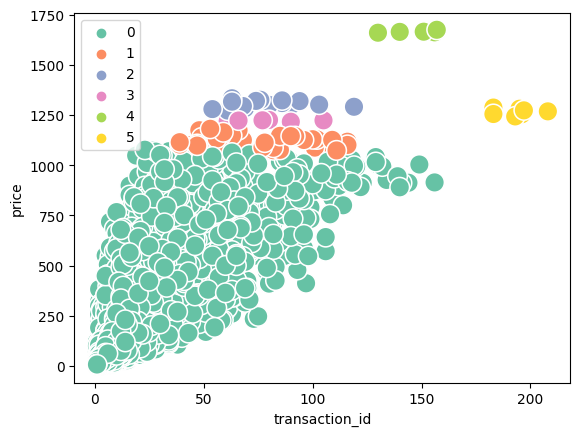

In [20]:
outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

#fig2, (axes) = plt.subplots(1,figsize=(12,5))

my_plot = sns.scatterplot(data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1], x='transaction_id', y='price',
                hue='Cluster', palette='Set2', legend='full', s=200)

#sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
#                data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1],
#                hue='Cluster', ax=axes[0], palette='Set2', legend='full', s=200)

#my_plot.scatter(outliers['transaction_id'], outliers['price'], s=10, label='outliers', c="k")
my_plot.legend()

plt.setp(get_legend().get_texts(), fontsize='12')

plt.show()

In [29]:
# use the product_id, quantity, price, and category_id columns to cluster customers into
# groups of those who have similar purchasing habits

# lets take only category and price
df_shortened = df_filtered[['category_id', 'price', 'customer_id']]

df_grouped = df_shortened.groupby(['customer_id', 'category_id']).price.sum().reset_index()

#frames = [df_grouped]
#df_grouped = pd.concat(frames, axis=1)

print(df_grouped[:10])

   customer_id  category_id   price
0            0          187   10.80
1            0          201    6.25
2            0          232   58.10
3            0          305   47.96
4            0          320  119.88
5            0          342   10.00
6            1          265    1.50
7            1          269    5.90
8            1          274    8.80
9            1          288    3.90


In [30]:
df_grouped = df_grouped[:20000]

print(df_grouped.shape)

print(df_grouped[:5])
print(len(df_grouped))

print(type(df_grouped))

(20000, 3)
   customer_id  category_id   price
0            0          187   10.80
1            0          201    6.25
2            0          232   58.10
3            0          305   47.96
4            0          320  119.88
20000
<class 'pandas.core.frame.DataFrame'>


In [42]:
clustering = DBSCAN(eps=50.0, min_samples=5).fit(df_grouped)
DBSCAN_dataset = df_grouped.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 

#To visualize the distribution of clusters, we will use value_counts() and convert it into a dataframe. 
#As you can see, we have 5 clusters and 1 outlier. The `0` cluster has the largest size with 112 rows. 

DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,19508
-1,401
4,18
5,10
8,9
6,8
10,7
1,6
13,6
3,5


NameError: name 'get_legend' is not defined

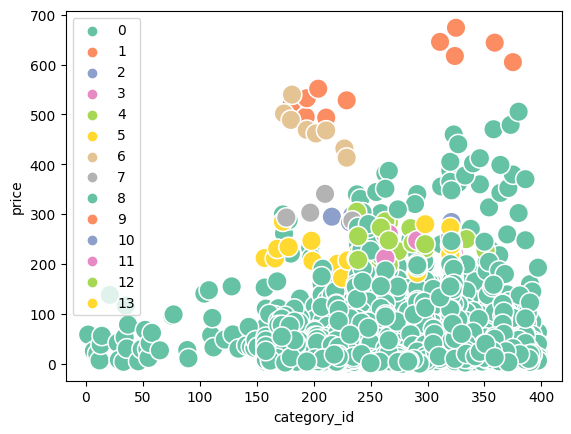

In [43]:
outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

my_plot = sns.scatterplot(data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1], x='category_id', y='price',
                hue='Cluster', palette='Set2', legend='full', s=200)
my_plot.legend()

plt.setp(get_legend().get_texts(), fontsize='12')

plt.show()

In [48]:
clustering = DBSCAN(eps=40.0, min_samples=5).fit(df_grouped)
DBSCAN_dataset = df_grouped.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 

#To visualize the distribution of clusters, we will use value_counts() and convert it into a dataframe. 
#As you can see, we have 5 clusters and 1 outlier. The `0` cluster has the largest size with 112 rows. 

DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,19309
-1,630
6,10
4,8
7,8
8,6
1,5
3,5
10,5
2,4


NameError: name 'get_legend' is not defined

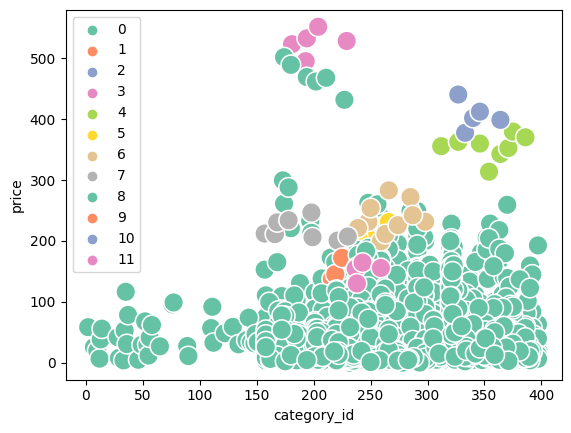

In [49]:
outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

my_plot = sns.scatterplot(data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1], x='category_id', y='price',
                hue='Cluster', palette='Set2', legend='full', s=200)
my_plot.legend()

plt.setp(get_legend().get_texts(), fontsize='12')

plt.show()